# Data Set

In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as tt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np


c:\Users\maxni\miniconda3\envs\ki-labor\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 1


class VisualWSDDataset(Dataset):
    def __init__(self, train, image_transform=None, text_transform=None, test_lang='en'):
        self.train = train
        self.image_transform = image_transform
        self.text_transform = text_transform

        self.base_path = './data/semeval-2023-task-1-V-WSD-train-v1/train_v1/'
        self.data_txt_path = self.base_path + 'train.data.v1.txt'
        self.gold_txt_path = self.base_path + 'train.gold.v1.txt'
        self.image_path = self.base_path + '/train_images_v1/'

        if not train:
            self.base_path = './data/'
            self.data_txt_path = self.base_path + test_lang + '.test.data.v1.1.txt'
            self.gold_txt_path = self.base_path + test_lang + '.test.gold.v1.1.txt'
            self.image_path = self.base_path + '/test_images_resized/'

            if test_lang == 'fa':
                self.data_txt_path = self.base_path + test_lang + '.test.data.txt'
                self.gold_txt_path = self.base_path + test_lang + '.test.gold.txt'
        

        # load txts
        self.data_df = pd.read_csv(self.data_txt_path, delimiter = "\t", header=None)
        self.gold_df = pd.read_csv(self.gold_txt_path, delimiter = "\t", header=None)
        self.data_gold_df  = pd.concat([self.data_df.iloc[:, 0], self.data_df.iloc[:, 1], self.gold_df.iloc[:, 0]], axis=1, keys=['label', 'label_context', 'img_name'])

    def __len__(self):
        return len(self.data_gold_df)

    def __getitem__(self, idx):
        label = self.data_gold_df.iloc[idx]['label']
        label_context = self.data_gold_df.iloc[idx]['label_context']
        correct_image_name = self.data_gold_df.iloc[idx]['img_name']
        images_series = self.data_df.iloc[idx][2:]
        correct_image_idx = images_series[images_series == correct_image_name].index[0]-2
        images = []
        for item in images_series:
                images.append(Image.open(self.image_path + item).convert('RGB'))
        correct_image = images[correct_image_idx]

        if self.image_transform:
            correct_image = self.image_transform(correct_image)
            for idx in range(len(images)):
                images[idx] = self.image_transform(images[idx])

        if self.text_transform:
            label = self.text_transform(label)
            label_context = self.text_transform(label_context)


        return {'label': label, 'label_context': label_context, 'correct_idx': correct_image_idx, 'correct_img': correct_image, 'imgs': images}

In [3]:
scale = tt.Resize((IMAGE_SIZE, IMAGE_SIZE))
tensor = tt.ToTensor()
image_composed = tt.transforms.Compose([scale, tensor])

In [4]:
train_set = VisualWSDDataset(train=True, image_transform=image_composed)
test_set = VisualWSDDataset(train=False, image_transform=image_composed, test_lang='it')

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
def visualize_set(data_set):
    for i, sample in enumerate(data_set):
        print(i, sample['label'], sample['label_context'], len(sample['imgs']), sample['correct_idx'])
        
        imshow(torchvision.utils.make_grid(sample['imgs']))
        imshow(sample['correct_img'])
        
        if i == 3:
            break

0 moorhen moorhen swamphen 10 5


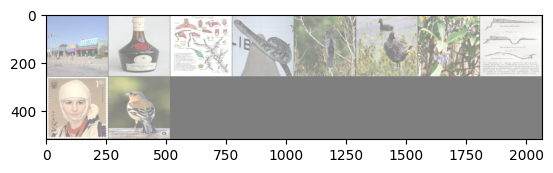

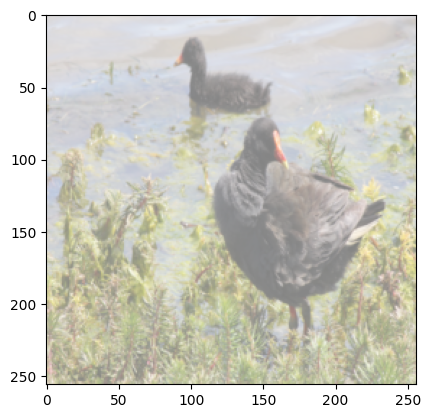

1 serinus serinus genus 10 5


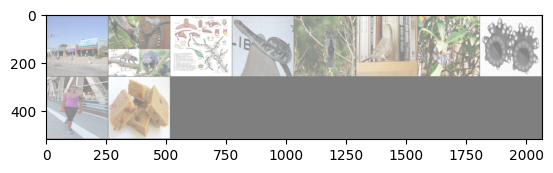

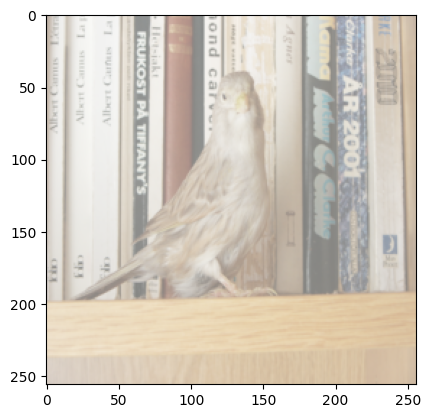

2 pegmatite pegmatite igneous 10 9


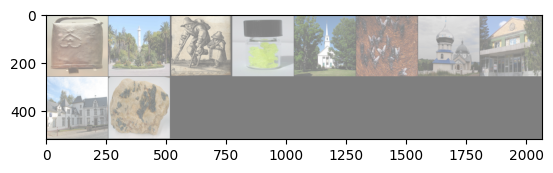

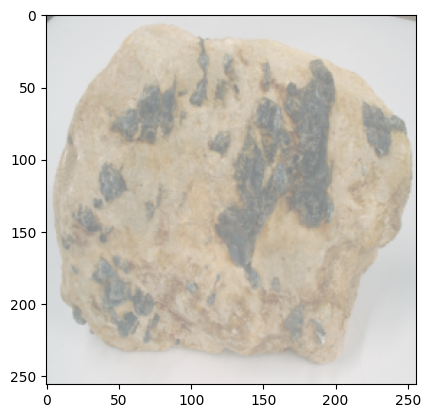

3 bangalores bangalores torpedo 10 4


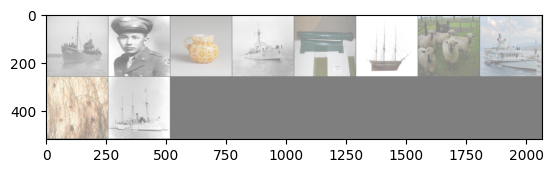

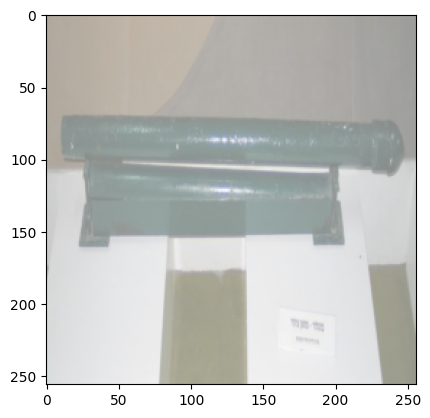

In [7]:
visualize_set(train_set)

0 gomma gomma per smacchiare 10 2


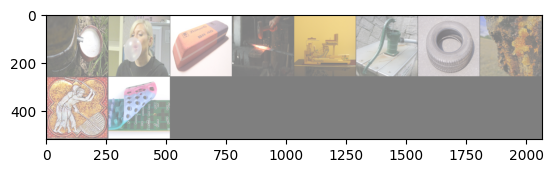

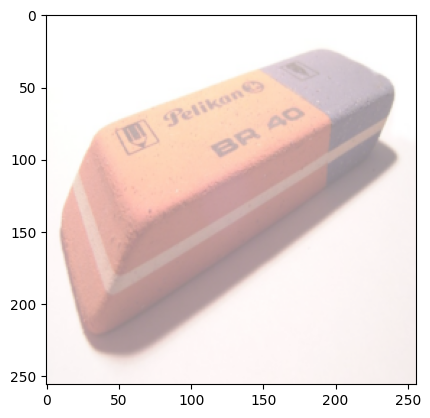

1 asino asino gioco di carte 10 0


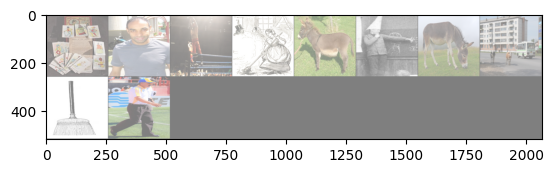

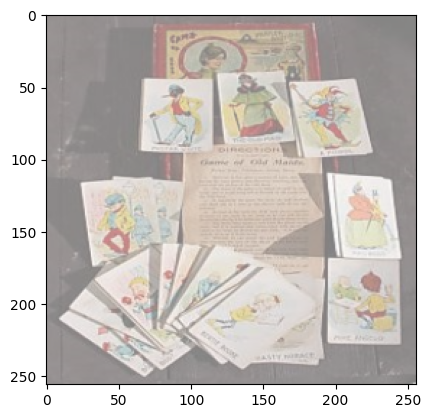

2 colonna colonna missione 10 6


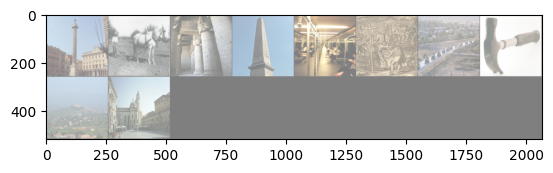

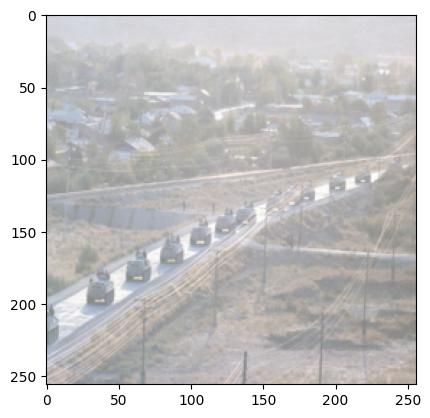

3 box box per infanti 10 5


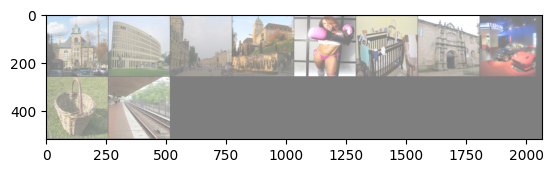

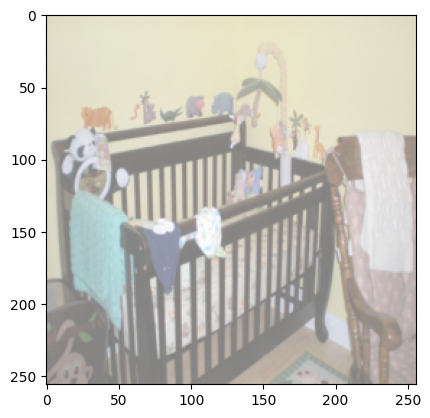

In [8]:
visualize_set(test_set)